# Jupyter Notebook Cells for Lagos Air Pollution Analysis

In [3]:
# Lagos Air Pollution and Respiratory Disease Analytics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_ind
import plotly.express as px
import plotly.graph_objects as go

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== LAGOS AIR POLLUTION AND RESPIRATORY DISEASE ANALYTICS ===")
print("Environment setup complete! 🚀")

=== LAGOS AIR POLLUTION AND RESPIRATORY DISEASE ANALYTICS ===
Environment setup complete! 🚀


In [4]:
def load_and_inspect_data():
    """Load the datasets and perform initial inspection"""

    print("\n📊 LOADING DATASETS...")

    # Load the datasets
    try:
        df1 = pd.read_csv('lagos_air_pollution_health_data1.csv')
        df2 = pd.read_csv('lagos_air_pollution_health_data2.csv')
        print(f"✅ Dataset 1 loaded successfully: {df1.shape}")
        print(f"✅ Dataset 2 loaded successfully: {df2.shape}")
    except FileNotFoundError as e:
        print(f"❌ Error loading datasets: {e}")
        return None, None

    # Initial inspection
    print("\n🔍 INITIAL DATA INSPECTION")
    print("-" * 40)

    print("\nDataset 1 Info:")
    print(f"Shape: {df1.shape}")
    print(f"Columns: {list(df1.columns)}")
    print(f"Memory usage: {df1.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print("\nDataset 2 Info:")
    print(f"Shape: {df2.shape}")
    print(f"Columns: {list(df2.columns)}")
    print(f"Memory usage: {df2.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Check for missing values
    print("\nMissing Values in Dataset 1:")
    missing1 = df1.isnull().sum()
    print(missing1[missing1 > 0])

    print("\nMissing Values in Dataset 2:")
    missing2 = df2.isnull().sum()
    print(missing2[missing2 > 0])

    # Display sample data
    print("\nSample from Dataset 1:")
    print(df1.head(3))

    print("\nSample from Dataset 2:")
    print(df2.head(3))

    return df1, df2

# Load and inspect data
df1, df2 = load_and_inspect_data()


📊 LOADING DATASETS...
✅ Dataset 1 loaded successfully: (258420, 16)
✅ Dataset 2 loaded successfully: (258420, 16)

🔍 INITIAL DATA INSPECTION
----------------------------------------

Dataset 1 Info:
Shape: (258420, 16)
Columns: ['City', 'date', 'pm2_5', 'pm10', 'no2', 'so2', 'o3', 'hospital_id', 'respiratory_cases', 'avg_age_of_patients', 'weather_temperature', 'weather_humidity', 'wind_speed', 'rainfall_mm', 'population_density', 'industrial_activity_index']
Memory usage: 68.10 MB

Dataset 2 Info:
Shape: (258420, 16)
Columns: ['C', 'date', 'pm2_5', 'pm10', 'no2', 'so2', 'o3', 'hospital_id', 'respiratory_cases', 'avg_age_of_patients', 'weather_temperature', 'weather_humidity', 'wind_speed', 'rainfall_mm', 'population_density', 'industrial_activity_index']
Memory usage: 67.95 MB

Missing Values in Dataset 1:
City                         28
date                         23
pm2_5                         3
pm10                          9
no2                           1
so2                 

# SECTION 3: DATA CLEANING AND STANDARDIZATION


In [5]:
def standardize_column_names(df):
    """Standardize column names across datasets"""
    print("   -> Standardizing column names...")

    # For the specific data structure you showed, we need to handle the merged column names
    if len(df.columns) == 1 and 'date' in str(df.columns[0]).lower():
        # Split the combined header if it exists
        combined_col = df.columns[0]

        # Expected column names based on your data description
        expected_columns = [
            'city', 'date', 'pm2_5', 'pm10', 'no2', 'so2', 'o3',
            'hospital_id', 'respiratory_cases', 'avg_age_of_patients',
            'weather_temperature', 'weather_humidity', 'wind_speed',
            'rainfall_mm', 'population_density', 'industrial_activity_index'
        ]

        # If we have the right number of actual data columns, use expected names
        if df.shape[1] == len(expected_columns):
            df.columns = expected_columns

    # Standardize all column names to lowercase and replace spaces
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Handle common variations
    column_mapping = {
        'c': 'city',
        'cdatepm2_5pm10no2so2o3hospital_idrespiratory_casesavg_age_of_patientsweather_temperatureweather_humiditywind_speedrainfall_mmpopulation_densityindustrial_activity_index': 'combined_data'
    }

    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            df = df.rename(columns={old_name: new_name})
    # Standardize all column names to lowercase and replace spaces
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    print("   ✅ Column names standardized.")
    return df

def clean_city_names(df):
    """Clean and standardize city names"""
    print("   -> Cleaning city names...")
    if 'city' in df.columns:
        city_mapping = {
            'AJAH': 'Ajah',
            'ajah': 'Ajah',
            'I K E J A': 'Ikeja',
            'IKEJA': 'Ikeja',
            'ikeja': 'Ikeja',
            'Ikeja': 'Ikeja',
            'YABA': 'Yaba',
            'yaba': 'Yaba',
            'SURULERE': 'Surulere',
            'surulere': 'Surulere',
            'LEKKI': 'Lekki',
            'lekki': 'Lekki'
        }

        df['city'] = df['city'].replace(city_mapping)
        df['city'] = df['city'].str.strip()

    print("   ✅ City names cleaned.")
    return df

def clean_and_convert_data_types(df):
    """Clean and convert data types appropriately"""

    print("\n🧹 CLEANING AND CONVERTING DATA TYPES...")

    # Clean date column - handle various date formats
    if 'date' in df.columns:
        # Attempt to parse with dayfirst=True first
        df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
        # If still NaT, try without dayfirst (assuming MM/DD/YYYY or similar)
        if df['date'].isnull().sum() > 0:
             df['date'] = pd.to_datetime(df['date'], errors='coerce')

        # Handle remaining missing dates - impute with the mode
        if df['date'].isnull().sum() > 0:
            mode_date = df['date'].mode()[0] if not df['date'].mode().empty else pd.NaT
            if pd.notna(mode_date):
                df['date'] = df['date'].fillna(mode_date)
                print(f"   -> Imputed {df['date'].isnull().sum()} missing dates with mode: {mode_date}.")
            else:
                 print("   -> Could not impute missing dates as mode is not available.")


        print("   -> Date column cleaned and converted.")

    # Define numeric columns
    numeric_columns = [
        'pm2_5', 'pm10', 'no2', 'so2', 'o3', 'respiratory_cases',
        'avg_age_of_patients', 'weather_temperature', 'weather_humidity',
        'wind_speed', 'rainfall_mm', 'population_density', 'industrial_activity_index'
    ]

    # Convert numeric columns
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    print("   -> Numeric columns converted.")

    # Clean hospital_id
    if 'hospital_id' in df.columns:
        df['hospital_id'] = df['hospital_id'].astype(str).str.strip()
        print("   -> Hospital ID cleaned.")

    print(f"✅ Data types converted successfully")
    return df

# Apply cleaning functions
print("Applying data cleaning functions...")
df1, df2 = load_and_inspect_data() # Moved loading to main pipeline or separate cell
df1_clean = standardize_column_names(df1.copy())
df2_clean = standardize_column_names(df2.copy())

df1_clean = clean_city_names(df1_clean)
df2_clean = clean_city_names(df2_clean)

df1_clean = clean_and_convert_data_types(df1_clean)
df2_clean = clean_and_convert_data_types(df2_clean)

print("Data cleaning completed! ✅")

Applying data cleaning functions...

📊 LOADING DATASETS...
✅ Dataset 1 loaded successfully: (258420, 16)
✅ Dataset 2 loaded successfully: (258420, 16)

🔍 INITIAL DATA INSPECTION
----------------------------------------

Dataset 1 Info:
Shape: (258420, 16)
Columns: ['City', 'date', 'pm2_5', 'pm10', 'no2', 'so2', 'o3', 'hospital_id', 'respiratory_cases', 'avg_age_of_patients', 'weather_temperature', 'weather_humidity', 'wind_speed', 'rainfall_mm', 'population_density', 'industrial_activity_index']
Memory usage: 68.10 MB

Dataset 2 Info:
Shape: (258420, 16)
Columns: ['C', 'date', 'pm2_5', 'pm10', 'no2', 'so2', 'o3', 'hospital_id', 'respiratory_cases', 'avg_age_of_patients', 'weather_temperature', 'weather_humidity', 'wind_speed', 'rainfall_mm', 'population_density', 'industrial_activity_index']
Memory usage: 67.95 MB

Missing Values in Dataset 1:
City                         28
date                         23
pm2_5                         3
pm10                          9
no2             

In [6]:
def handle_missing_values(df):
    """Handle missing values using various imputation strategies"""

    print("\n🔧 HANDLING MISSING VALUES...")

    # Check missing values before imputation
    missing_before = df.isnull().sum()
    print(f"Total missing values before imputation: {missing_before.sum()}")
    if missing_before.sum() > 0:
        print("Missing values before imputation:")
        print(missing_before[missing_before > 0])

    # Strategy 1: Forward fill for time series data
    time_series_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'o3']
    for col in time_series_cols:
        if col in df.columns:
            df[col] = df.groupby('city')[col].fillna(method='ffill')
            df[col] = df.groupby('city')[col].fillna(method='bfill')
    print("   -> Time series columns imputed using ffill and bfill.")

    # Strategy 2: Mean imputation for weather data (grouped by city and month)
    weather_cols = ['weather_temperature', 'weather_humidity', 'wind_speed', 'rainfall_mm']
    for col in weather_cols:
        if col in df.columns and 'date' in df.columns:
            df['month'] = df['date'].dt.month
            df[col] = df.groupby(['city', 'month'])[col].transform(
                lambda x: x.fillna(x.mean())
            )
    print("   -> Weather columns imputed using grouped mean.")


    # Strategy 3: KNN imputation for remaining numerical features
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numerical_cols) > 0:
        imputer = KNNImputer(n_neighbors=5)
        df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
        print("   -> Remaining numerical columns imputed using KNN.")


    # Strategy 4: Mode imputation for categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        if col != 'date':
            mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
            df[col] = df[col].fillna(mode_value)
    print("   -> Categorical columns imputed using mode.")


    # Check missing values after imputation
    missing_after = df.isnull().sum()
    print(f"Total missing values after imputation: {missing_after.sum()}")
    if missing_after.sum() > 0:
        print("Missing values after imputation:")
        print(missing_after[missing_after > 0])
    else:
        print("✅ No missing values remaining.")


    return df

In [9]:
def remove_duplicates(df, subset_cols=None):
    """Remove duplicate records with a more cautious approach."""

    print("\n🗑️ REMOVING DUPLICATES...")

    initial_shape = df.shape
    print(f"Initial dataset shape: {initial_shape}")

    # Remove exact duplicates across all columns
    df_exact_duplicates_removed = df.drop_duplicates()
    exact_duplicates_removed_count = initial_shape[0] - df_exact_duplicates_removed.shape[0]
    print(f"Shape after removing exact duplicates: {df_exact_duplicates_removed.shape}")
    print(f"Removed {exact_duplicates_removed_count} exact duplicate records.")

    df = df_exact_duplicates_removed # Continue with the dataframe after removing exact duplicates

    # Optional: Remove duplicates based on a subset of key columns
    if subset_cols:
        existing_subset_cols = [col for col in subset_cols if col in df.columns]
        if existing_subset_cols:
            print(f"\nAttempting to remove duplicates based on subset: {existing_subset_cols}")
            df_subset_duplicates_removed = df.drop_duplicates(subset=existing_subset_cols, keep='first')
            subset_duplicates_removed_count = df.shape[0] - df_subset_duplicates_removed.shape[0]
            df = df_subset_duplicates_removed
            print(f"Shape after removing subset duplicates: {df.shape}")
            print(f"Removed {subset_duplicates_removed_count} subset duplicate records.")
        else:
            print("Warning: None of the specified subset columns were found in the DataFrame. Skipping subset duplicate removal.")


    final_shape = df.shape
    total_removed_duplicates = initial_shape[0] - final_shape[0]

    print(f"\nTotal removed duplicate records: {total_removed_duplicates}")
    print(f"Final dataset shape: {final_shape}")
    print("✅ Duplicate removal complete.")

    return df

# To remove only exact duplicates:
# cleaned_df = remove_duplicates(cleaned_df)

In [10]:
def detect_and_handle_outliers(df):
    """Detect and handle outliers using IQR method"""

    print("\n📈 DETECTING AND HANDLING OUTLIERS...")

    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    outlier_summary = {}

    for col in numerical_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_count = len(outliers)

            if outlier_count > 0:
                outlier_summary[col] = outlier_count

                # Cap outliers instead of removing them (to preserve data)
                df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
                df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    if outlier_summary:
        print("Outliers detected and capped:")
        for col, count in outlier_summary.items():
            print(f"  {col}: {count} outliers")
        print("✅ Outlier handling complete.")
    else:
        print("No significant outliers detected")
        print("✅ Outlier detection complete.")
    return df

# SECTION 4: FEATURE ENGINEERING


In [11]:
def create_derived_features(df):
    """Create new features from existing data"""

    print("\n⚙️ CREATING DERIVED FEATURES...")

    # Create pollution index (composite feature)
    pollution_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'o3']
    existing_pollution_cols = [col for col in pollution_cols if col in df.columns]

    if len(existing_pollution_cols) >= 3:
        print(f"   -> Found pollution columns: {existing_pollution_cols}")
        # Normalize each pollutant to 0-100 scale before combining
        scaler = StandardScaler()
        normalized_pollution = scaler.fit_transform(df[existing_pollution_cols])

        # Create weighted pollution index (PM2.5 and PM10 have higher weights)
        weights = {'pm2_5': 0.3, 'pm10': 0.25, 'no2': 0.2, 'so2': 0.15, 'o3': 0.1}

        df['pollution_index'] = 0
        for i, col in enumerate(existing_pollution_cols):
            weight = weights.get(col, 0.1)
            df['pollution_index'] += normalized_pollution[:, i] * weight

        # Scale to 0-100
        df['pollution_index'] = (df['pollution_index'] - df['pollution_index'].min()) / \
                               (df['pollution_index'].max() - df['pollution_index'].min()) * 100
        print("   -> Created 'pollution_index'.")
        print(df['pollution_index'].head())

    # Create time-based features
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day_of_year'] = df['date'].dt.dayofyear
        df['quarter'] = df['date'].dt.quarter
        df['is_harmattan'] = ((df['month'] >= 12) | (df['month'] <= 2)).astype(int)
        df['season'] = df['month'].map({
            12: 'Dry', 1: 'Dry', 2: 'Dry',
            3: 'Dry', 4: 'Wet', 5: 'Wet',
            6: 'Wet', 7: 'Wet', 8: 'Wet',
            9: 'Wet', 10: 'Dry', 11: 'Dry'
        })
        print("   -> Created time-based features ('year', 'month', 'day_of_year', 'quarter', 'is_harmattan', 'season').")


    # Create air quality categories
    if 'pm2_5' in df.columns:
        df['pm2_5_category'] = pd.cut(df['pm2_5'],
                                     bins=[0, 15, 30, 55, 110, float('inf')],
                                     labels=['Good', 'Moderate', 'Unhealthy for Sensitive',
                                           'Unhealthy', 'Very Unhealthy'])
        print("   -> Created 'pm2_5_category'.")


    # Create health risk indicators
    if 'respiratory_cases' in df.columns:
        df['high_respiratory_risk'] = (df['respiratory_cases'] >
                                      df['respiratory_cases'].quantile(0.75)).astype(int)
        print("   -> Created 'high_respiratory_risk'.")

    # Create population-adjusted metrics
    if 'respiratory_cases' in df.columns and 'population_density' in df.columns:
        df['cases_per_thousand'] = (df['respiratory_cases'] / df['population_density']) * 1000
        print("   -> Created 'cases_per_thousand'.")

    # Create weather comfort index
    weather_cols = ['weather_temperature', 'weather_humidity']
    if all(col in df.columns for col in weather_cols):
        # Simple comfort index based on temperature and humidity
        df['weather_comfort_index'] = (
            np.where(df['weather_temperature'].between(20, 30) &
                    df['weather_humidity'].between(40, 60), 1, 0)
        )
        print("   -> Created 'weather_comfort_index'.")

    new_features = [
        'pollution_index', 'year', 'month', 'season', 'is_harmattan',
        'pm2_5_category', 'high_respiratory_risk', 'cases_per_thousand', 'weather_comfort_index'
    ]
    created = [col for col in df.columns if col in new_features]

    print(f"\n✅ Created {len(created)} new features: {created}")
    print("✅ Feature creation complete.")

    return df

In [15]:
def merge_datasets(df1, df2):
    """Merge the two datasets"""

    print("\n🔗 MERGING DATASETS...")

    # Ensure both datasets have the same structure
    df1_clean = clean_dataset(df1.copy())
    df2_clean = clean_dataset(df2.copy())

    # Add source identifier
    df1_clean['data_source'] = 'dataset_1'
    df2_clean['data_source'] = 'dataset_2'

    # Concatenate datasets
    merged_df = pd.concat([df1_clean, df2_clean], ignore_index=True)

    print(f"Merged dataset shape: {merged_df.shape}")

    return merged_df


merged_df = merge_datasets(df1.copy(), df2.copy())


🔗 MERGING DATASETS...
   -> Standardizing column names...
   ✅ Column names standardized.
   -> Cleaning city names...
   ✅ City names cleaned.

🧹 CLEANING AND CONVERTING DATA TYPES...
   -> Imputed 0 missing dates with mode: 2021-01-04 00:00:00.
   -> Date column cleaned and converted.
   -> Numeric columns converted.
   -> Hospital ID cleaned.
✅ Data types converted successfully

🔧 HANDLING MISSING VALUES...
Total missing values before imputation: 123
Missing values before imputation:
city                         28
pm2_5                         3
pm10                          9
no2                           1
so2                           8
o3                            7
respiratory_cases             7
avg_age_of_patients          16
weather_temperature           4
weather_humidity              6
wind_speed                    4
rainfall_mm                   3
population_density           22
industrial_activity_index     5
dtype: int64
   -> Time series columns imputed using ffill 

In [18]:
def clean_dataset(df):
    """Apply all cleaning functions to a dataset"""
    print("\nApplying comprehensive cleaning to a dataset...")

    df = standardize_column_names(df)
    # Assuming parse_combined_data is not needed based on current data structure
    # df = parse_combined_data(df)
    df = clean_city_names(df)
    df = clean_and_convert_data_types(df)
    df = handle_missing_values(df)
    df = remove_duplicates(df)
    df = create_derived_features(df)

    print("✅ Comprehensive cleaning complete.")
    return df

# To run this cell independently, you need to define 'df' first, e.g.:
df = merged_df.copy() # Assuming merged_df is available
cleaned_df = clean_dataset(df)


Applying comprehensive cleaning to a dataset...
   -> Standardizing column names...
   ✅ Column names standardized.
   -> Cleaning city names...
   ✅ City names cleaned.

🧹 CLEANING AND CONVERTING DATA TYPES...
   -> Date column cleaned and converted.
   -> Numeric columns converted.
   -> Hospital ID cleaned.
✅ Data types converted successfully

🔧 HANDLING MISSING VALUES...
Total missing values before imputation: 0
   -> Time series columns imputed using ffill and bfill.
   -> Weather columns imputed using grouped mean.
   -> Remaining numerical columns imputed using KNN.
   -> Categorical columns imputed using mode.
Total missing values after imputation: 0
✅ No missing values remaining.

🗑️ REMOVING DUPLICATES...
Initial dataset shape: (516840, 28)
Shape after removing exact duplicates: (516840, 28)
Removed 0 exact duplicate records.

Total removed duplicate records: 0
Final dataset shape: (516840, 28)
✅ Duplicate removal complete.

⚙️ CREATING DERIVED FEATURES...
   -> Found pollut

In [20]:
# Save the cleaned dataset after the cleaning step
try:
    cleaned_df.to_csv('lagos_cleaned_dataset.csv', index=False)
    print("✅ Cleaned dataset (after cleaning) saved as 'lagos_cleaned_dataset.csv'")
except Exception as e:
    print(f"❌ Error saving cleaned dataset: {e}")

✅ Cleaned dataset (after cleaning) saved as 'lagos_cleaned_dataset.csv'


# SECTION 5: EXPLORATORY DATA ANALYSIS (EDA)


📊 PERFORMING EXPLORATORY DATA ANALYSIS...

1. DATASET OVERVIEW
------------------------------
Dataset shape: (516840, 28)
Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00
Cities covered: 6
Cities: ['Ajah' 'Ikeja' 'Lekki' 'Surulere' 'Yaba' 'A J A H']

2. STATISTICAL SUMMARY
------------------------------
               pm2_5           pm10            no2            so2  \
count  516840.000000  516840.000000  516840.000000  516840.000000   
mean       61.353005      92.111531      40.948391      15.340595   
std        16.550586      22.566728      11.043574       5.342411   
min        16.755000      31.440000      11.215000       0.900000   
25%        49.950000      76.560000      33.340000      11.670000   
50%        60.690000      91.100000      40.510000      15.180000   
75%        72.070000     106.640000      48.090000      18.850000   
max       105.275000     151.760000      70.215000      29.620000   

                  o3  respiratory_cases  avg_age_of_patients  \
co

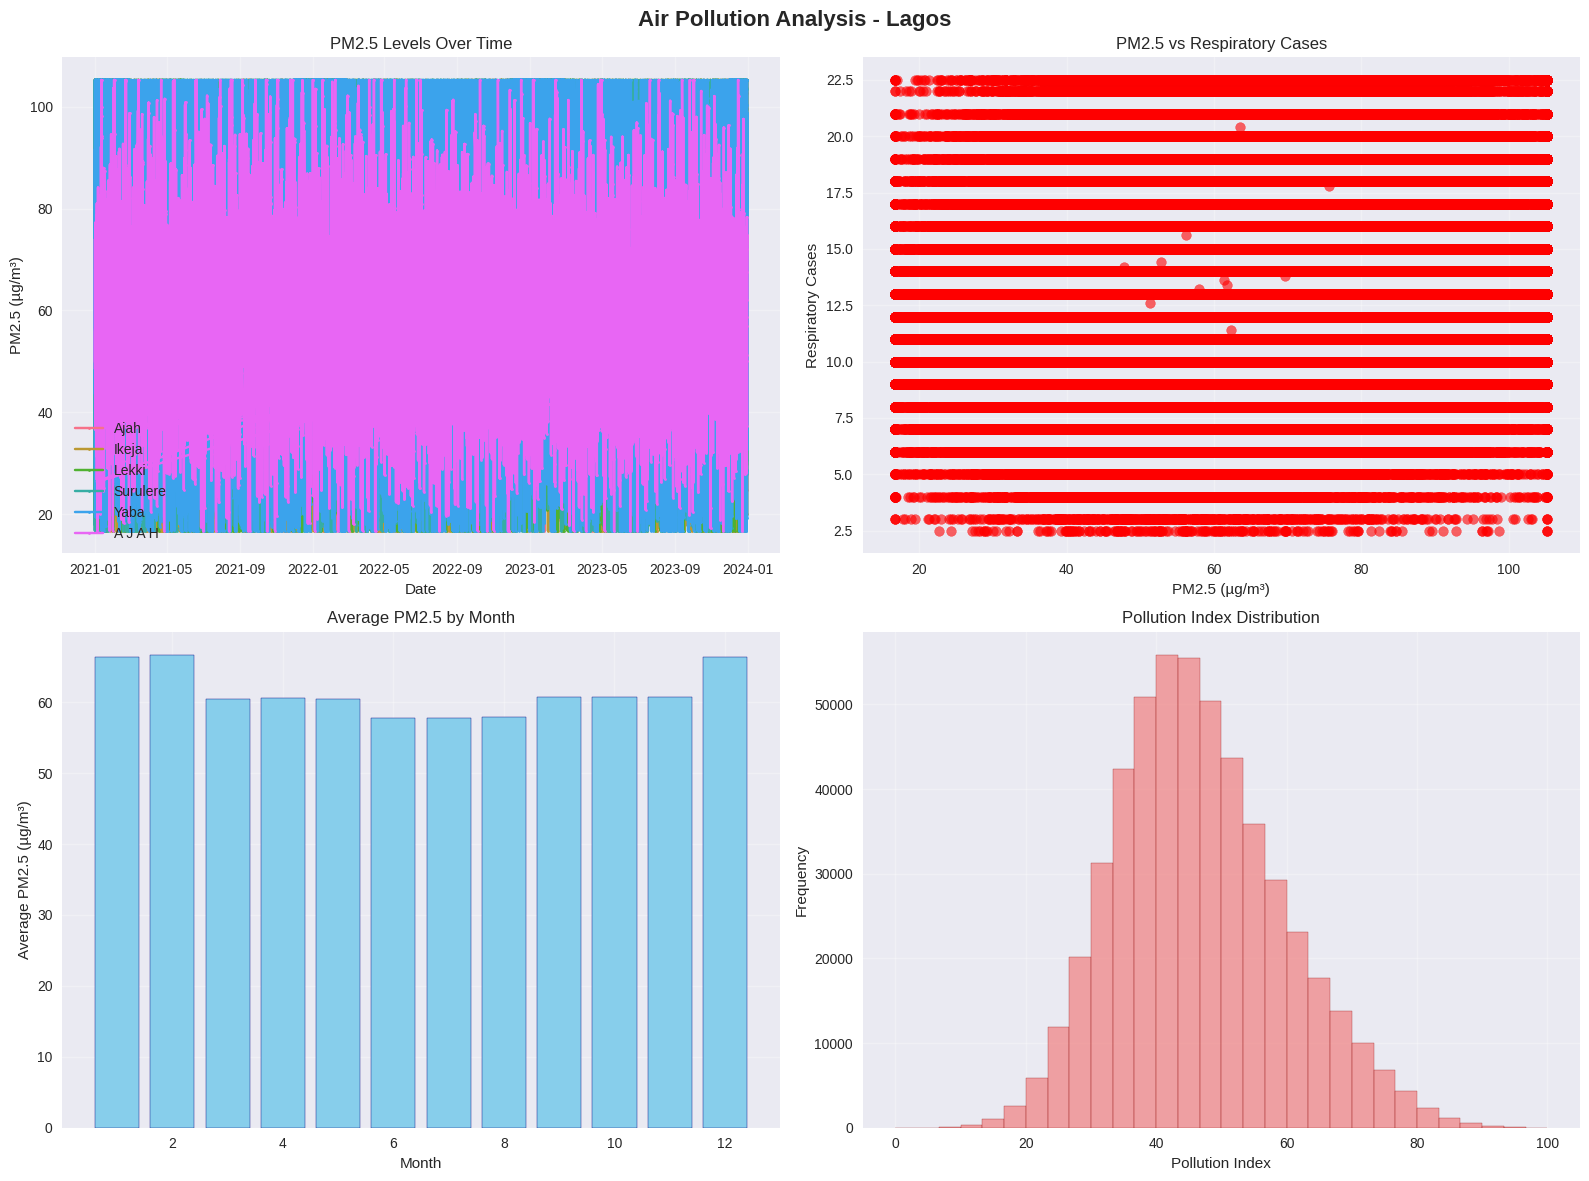


📊 Creating Correlation Matrix (Key Features)...


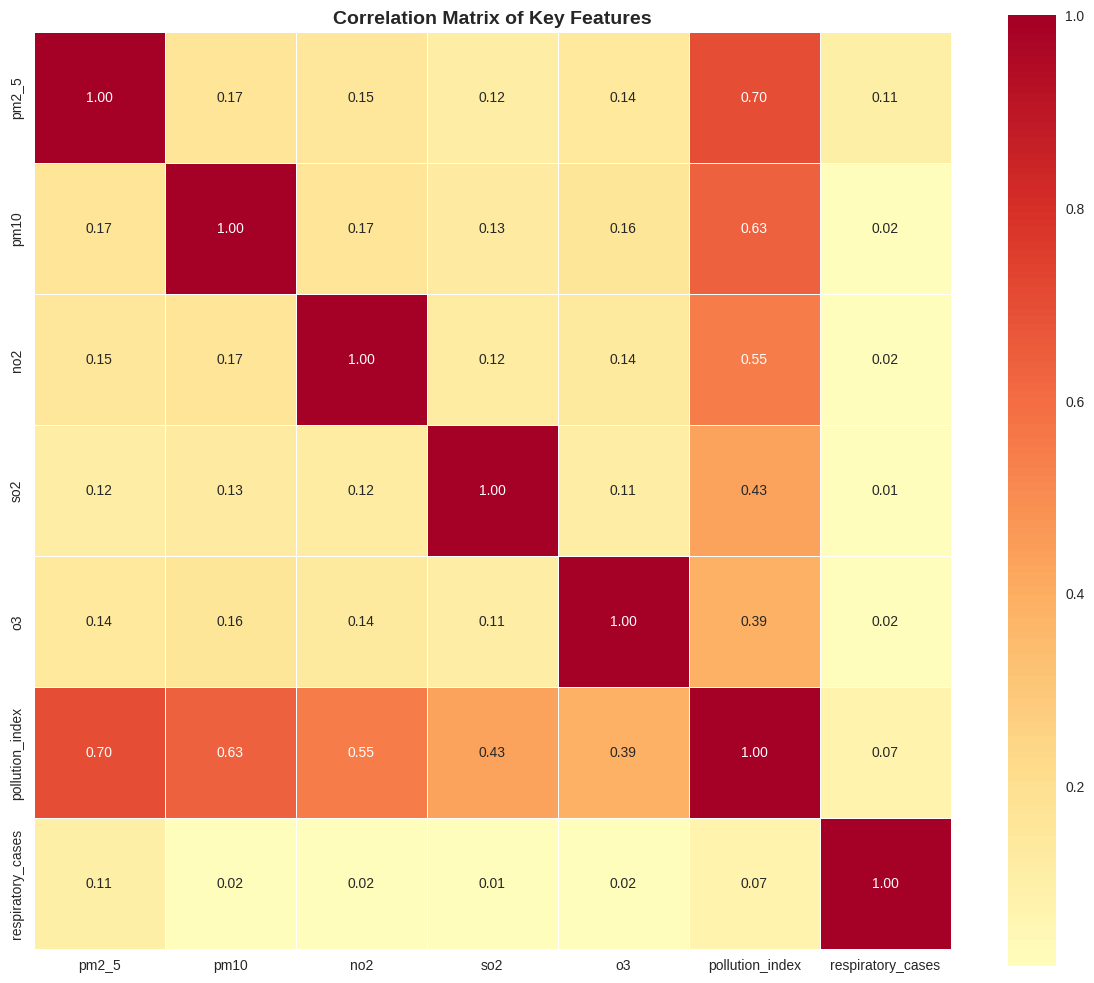

✅ Correlation matrix of key features visualized.


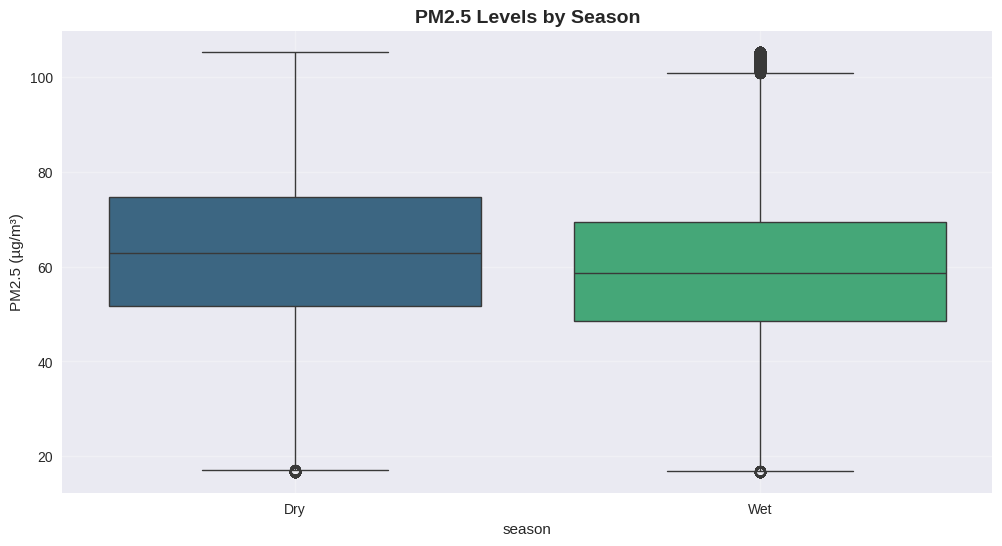


📊 Creating Overlay Plot: Pollution Index vs. Respiratory Cases...


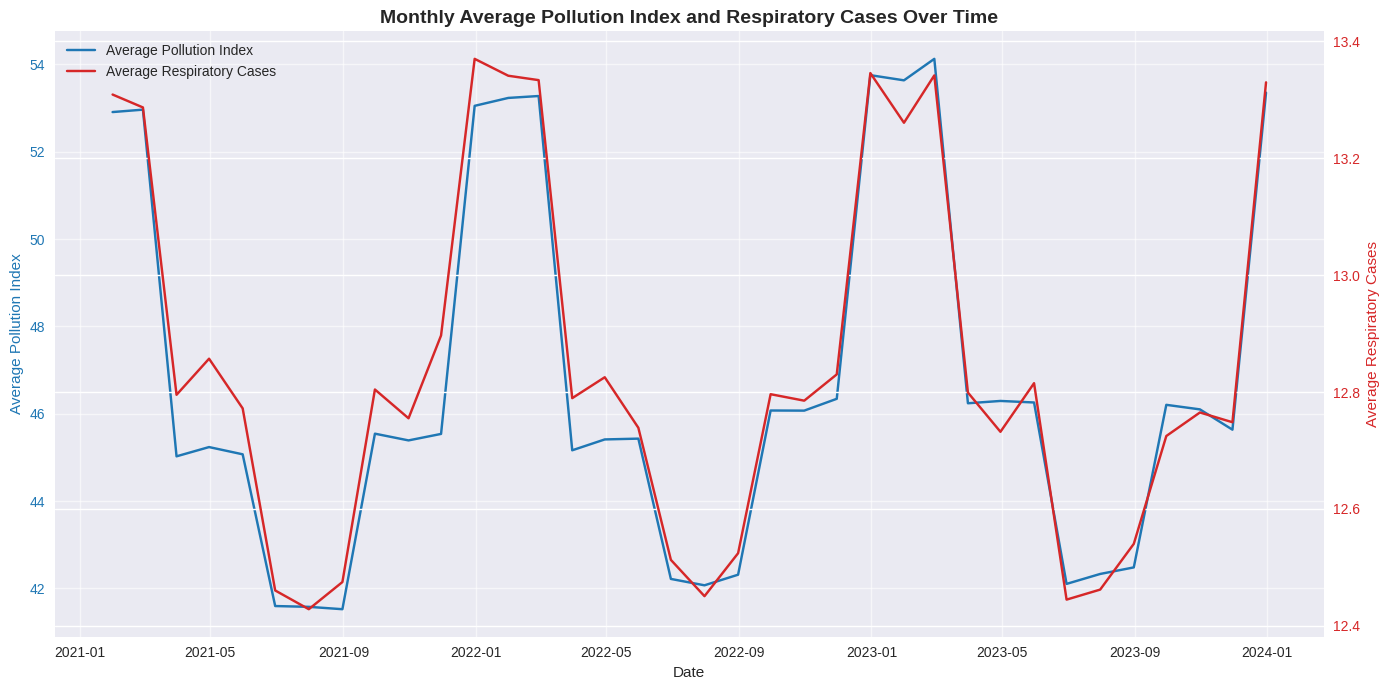

✅ Overlay plot for Average Pollution Index and Respiratory Cases created.

📊 Visualizing Average Monthly Pollution Trends (All Cities Combined) with Pollutant Legends...


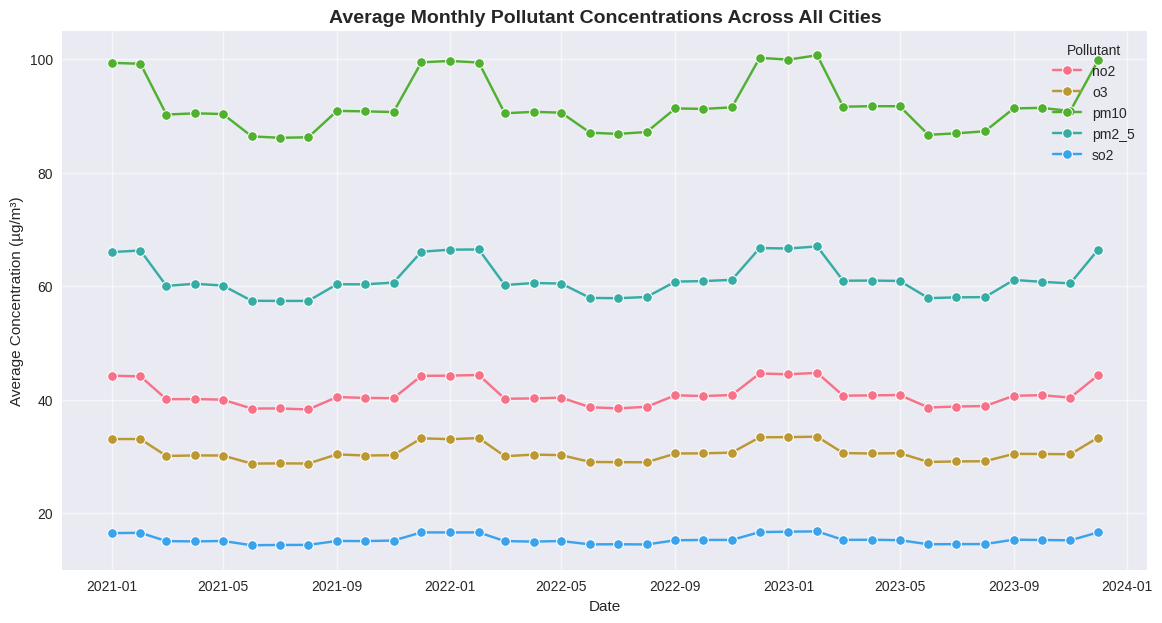

✅ Average Monthly Pollutant Trends (All Cities Combined) visualized with Pollutant Legends.


In [22]:
def perform_eda(df):
    """Comprehensive Exploratory Data Analysis"""

    print("\n📊 PERFORMING EXPLORATORY DATA ANALYSIS...")
    print("=" * 50)

    # Dataset overview
    print("\n1. DATASET OVERVIEW")
    print("-" * 30)
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Cities covered: {df['city'].nunique() if 'city' in df.columns else 'N/A'}")
    if 'city' in df.columns:
        print(f"Cities: {df['city'].unique()}")

    # Statistical summary
    print("\n2. STATISTICAL SUMMARY")
    print("-" * 30)
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    print(df[numerical_cols].describe())

    # Missing values summary
    print("\n3. DATA QUALITY CHECK")
    print("-" * 30)
    missing_summary = df.isnull().sum()
    if missing_summary.sum() > 0:
        print("Missing values:")
        print(missing_summary[missing_summary > 0])
    else:
        print("No missing values detected")

    return df

def create_visualizations(df):
    """Create comprehensive visualizations"""

    print("\n📈 CREATING VISUALIZATIONS...")

    # Set up the plotting parameters
    plt.rcParams['figure.figsize'] = (15, 10)

    # 1. Pollution trends over time
    if 'date' in df.columns and 'pm2_5' in df.columns:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Air Pollution Analysis - Lagos', fontsize=16, fontweight='bold')

        # PM2.5 trends by city
        if 'city' in df.columns:
            for city in df['city'].unique():
                city_data = df[df['city'] == city]
                axes[0, 0].plot(city_data['date'], city_data['pm2_5'],
                               label=city, marker='o', markersize=2)
        else:
            axes[0, 0].plot(df['date'], df['pm2_5'], marker='o', markersize=2)

        axes[0, 0].set_title('PM2.5 Levels Over Time')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('PM2.5 (µg/m³)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Pollution vs Respiratory cases
        if 'respiratory_cases' in df.columns:
            axes[0, 1].scatter(df['pm2_5'], df['respiratory_cases'],
                             alpha=0.6, c='red')
            axes[0, 1].set_title('PM2.5 vs Respiratory Cases')
            axes[0, 1].set_xlabel('PM2.5 (µg/m³)')
            axes[0, 1].set_ylabel('Respiratory Cases')
            axes[0, 1].grid(True, alpha=0.3)

        # Monthly patterns
        if 'month' in df.columns:
            monthly_pollution = df.groupby('month')['pm2_5'].mean()
            axes[1, 0].bar(monthly_pollution.index, monthly_pollution.values,
                          color='skyblue', edgecolor='navy')
            axes[1, 0].set_title('Average PM2.5 by Month')
            axes[1, 0].set_xlabel('Month')
            axes[1, 0].set_ylabel('Average PM2.5 (µg/m³)')
            axes[1, 0].grid(True, alpha=0.3)

        # Pollution index distribution
        if 'pollution_index' in df.columns:
            axes[1, 1].hist(df['pollution_index'], bins=30,
                           color='lightcoral', edgecolor='darkred', alpha=0.7)
            axes[1, 1].set_title('Pollution Index Distribution')
            axes[1, 1].set_xlabel('Pollution Index')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # 2. Correlation heatmap (Key Features only)
    print("\n📊 Creating Correlation Matrix (Key Features)...")

    # Define key features for the correlation matrix
    key_features = [
        'pm2_5', 'pm10', 'no2', 'so2', 'o3', 'pollution_index',
        'respiratory_cases',
    ]

    # Filter for existing key features in the DataFrame
    existing_key_features = [col for col in key_features if col in df.columns]

    if len(existing_key_features) > 1: # Need at least 2 columns for correlation
        plt.figure(figsize=(12, 10))
        correlation_matrix = df[existing_key_features].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r',
                   center=0, square=True, linewidths=0.5, fmt=".2f") # Format annotations
        plt.title('Correlation Matrix of Key Features',
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("✅ Correlation matrix of key features visualized.")
    else:
        print("Skipping key feature correlation matrix: Not enough key features found in the DataFrame.")


    # 3. Seasonal analysis
    if 'season' in df.columns and 'pm2_5' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='season', y='pm2_5', palette='viridis')
        plt.title('PM2.5 Levels by Season', fontsize=14, fontweight='bold')
        plt.ylabel('PM2.5 (µg/m³)')
        plt.grid(True, alpha=0.3)
        plt.show()

    # Dashboard Visualization: Overlay Plot - Pollution Index vs. Respiratory Cases (Monthly Average)

    print("\n📊 Creating Overlay Plot: Pollution Index vs. Respiratory Cases...")

    if 'date' in cleaned_df.columns and 'pollution_index' in cleaned_df.columns and 'respiratory_cases' in cleaned_df.columns:

        # Calculate monthly average pollution index
        monthly_pollution_index = cleaned_df.set_index('date')['pollution_index'].resample('M').mean()

        # Calculate monthly average respiratory cases (summing daily cases first, then averaging monthly sums)
        # A more appropriate KPI might be total monthly cases, but the user asked for average monthly cases.
        # Let's stick to average monthly cases as requested, but note that total cases is also a valid metric.
        monthly_cases = cleaned_df.set_index('date')['respiratory_cases'].resample('M').mean()


        # Create a figure and a primary axes
        fig, ax1 = plt.subplots(figsize=(14, 7))

        # Plot Average Pollution Index on the primary axes
        ax1.plot(monthly_pollution_index.index, monthly_pollution_index.values, color='tab:blue', label='Average Pollution Index')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Average Pollution Index', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True, alpha=0.6)

        # Create a secondary axes that shares the same x-axis
        ax2 = ax1.twinx()

        # Plot Average Respiratory Cases on the secondary axes
        ax2.plot(monthly_cases.index, monthly_cases.values, color='tab:red', label='Average Respiratory Cases')
        ax2.set_ylabel('Average Respiratory Cases', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Add a title
        plt.title('Monthly Average Pollution Index and Respiratory Cases Over Time', fontsize=14, fontweight='bold')

        # Combine legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')


        plt.tight_layout()
        plt.show()

        print("✅ Overlay plot for Average Pollution Index and Respiratory Cases created.")

    else:
        print("Skipping overlay plot: Required columns ('date', 'pollution_index', 'respiratory_cases') not found.")

    # KPI Plot: Average Monthly Pollution Trends (All Cities Combined) with Pollutant Legends

    print("\n📊 Visualizing Average Monthly Pollution Trends (All Cities Combined) with Pollutant Legends...")

    # Select key pollutant columns
    pollutant_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'o3']
    existing_pollutant_cols = [col for col in pollutant_cols if col in cleaned_df.columns]

    if 'date' in cleaned_df.columns and existing_pollutant_cols:
        # Prepare data for plotting - melt the DataFrame to long format
        # Group by date and take the mean across all locations for each pollutant
        daily_avg_pollutants = cleaned_df.groupby('date')[existing_pollutant_cols].mean().reset_index()

        # Melt the DataFrame to have pollutant names as a variable for seaborn hue
        pollutants_long = daily_avg_pollutants.melt(id_vars='date',
                                                    value_vars=existing_pollutant_cols,
                                                    var_name='Pollutant',
                                                    value_name='Concentration')

        # Resample to monthly average for smoother trends
        pollutants_long['month'] = pollutants_long['date'].dt.to_period('M')
        monthly_avg_pollutants = pollutants_long.groupby(['month', 'Pollutant'])['Concentration'].mean().reset_index()
        monthly_avg_pollutants['month'] = monthly_avg_pollutants['month'].dt.to_timestamp()


        plt.figure(figsize=(14, 7))
        sns.lineplot(data=monthly_avg_pollutants, x='month', y='Concentration', hue='Pollutant', marker='o') # Added marker='o' for data points

        plt.title('Average Monthly Pollutant Concentrations Across All Cities', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Average Concentration (µg/m³)')
        plt.grid(True, alpha=0.6)
        plt.legend(title='Pollutant') # Explicitly add legend for pollutants
        plt.show()

        print("✅ Average Monthly Pollutant Trends (All Cities Combined) visualized with Pollutant Legends.")

    else:
        print("Skipping pollutant trend visualization: Required columns ('date' and at least one pollutant) not found.")

# Perform Exploratory Data Analysis and create visualizations
cleaned_df = perform_eda(merged_df) # Assuming merged_df is available from previous steps
create_visualizations(cleaned_df) # Call this function after defining it and ensuring cleaned_df is ready

# SECTION 6: PREDICTIVE MODELING


## Prepare Modelling Data

In [48]:
def prepare_optimized_modeling_data(df):
    """Prepare data for machine learning models using core features only"""
    print("\n🤖 PREPARING OPTIMIZED MODELING DATA...")

    # Define core features based on importance analysis
    core_features = [
        'high_respiratory_risk',
        'cases_per_thousand',
        'population_density',
        'pm2_5',                    # Primary pollution metric
        'pm10',                     # Secondary pollution metric
        'weather_humidity',         # Affects pollution dispersion
    ]

    # Verify features exist in dataset
    available_features = [col for col in core_features if col in df.columns]
    print(f"Using core features: {available_features}")

    # Target variable
    target_col = 'respiratory_cases'

    if target_col not in df.columns:
        print(f"❌ Target variable '{target_col}' not found in dataset")
        return None, None, None, None

    # Create feature matrix and target vector
    X = df[available_features].copy()
    y = df[target_col].copy()

    # Remove rows with missing target values
    mask = ~y.isnull() & X.notnull().all(axis=1)
    X = X[mask]
    y = y[mask]

    print(f"✅ Optimized modeling data prepared:")
    print(f"   Features shape: {X.shape}")
    print(f"   Target shape: {y.shape}")
    print(f"   Features used: {available_features}")

    return X, y, available_features, df

# Prepare optimized modeling data
X_opt, y_opt, feature_names_opt, model_df_opt = prepare_optimized_modeling_data(cleaned_df)


🤖 PREPARING OPTIMIZED MODELING DATA...
Using core features: ['high_respiratory_risk', 'cases_per_thousand', 'population_density', 'pm2_5', 'pm10', 'weather_humidity']
✅ Optimized modeling data prepared:
   Features shape: (516840, 6)
   Target shape: (516840,)
   Features used: ['high_respiratory_risk', 'cases_per_thousand', 'population_density', 'pm2_5', 'pm10', 'weather_humidity']


## Build & Evaluate Model

In [49]:
def build_optimized_models(X, y, feature_names):
    """Build and evaluate optimized machine learning models"""
    print("\n🏗️ BUILDING OPTIMIZED MODELS...")
    print("=" * 40)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize optimized models (faster versions)
    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=50,  # Reduced from 100
            max_depth=10,     # Limit depth
            min_samples_split=5,
            random_state=42,
            n_jobs=-1         # Use all cores
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=50,  # Reduced from 100
            max_depth=6,      # Limit depth
            learning_rate=0.1,
            random_state=42
        )
    }

    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n🔄 Training {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)

        # Cross-validation score (faster with 3-fold)
        cv_scores = cross_val_score(model, X_train, y_train,
                                   cv=3, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores.mean())

        results[name] = {
            'model': model,
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'cv_rmse': cv_rmse,
            'predictions': y_pred
        }

        print(f"   ✅ {name} Results:")
        print(f"      RMSE: {rmse:.3f}")
        print(f"      MAE: {mae:.3f}")
        print(f"      R²: {r2:.3f}")
        print(f"      CV RMSE: {cv_rmse:.3f}")

    # Feature importance analysis
    print("\n📊 FEATURE IMPORTANCE ANALYSIS")
    print("=" * 35)

    for name, result in results.items():
        if hasattr(result['model'], 'feature_importances_'):
            importances = result['model'].feature_importances_
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            print(f"\n{name} - Feature Importance:")
            print(feature_importance.to_string(index=False))

    return results, X_test, y_test

# Build optimized models
if X_opt is not None:
    optimized_results, X_test_opt, y_test_opt = build_optimized_models(X_opt, y_opt, feature_names_opt)
else:
    print("Optimized modeling data preparation failed. Cannot proceed with modeling.")


🏗️ BUILDING OPTIMIZED MODELS...

🔄 Training Random Forest...
   ✅ Random Forest Results:
      RMSE: 0.238
      MAE: 0.094
      R²: 0.996
      CV RMSE: 0.239

🔄 Training Gradient Boosting...
   ✅ Gradient Boosting Results:
      RMSE: 0.128
      MAE: 0.095
      R²: 0.999
      CV RMSE: 0.129

📊 FEATURE IMPORTANCE ANALYSIS

Random Forest - Feature Importance:
              feature   importance
high_respiratory_risk 5.786358e-01
   cases_per_thousand 2.900879e-01
   population_density 1.312758e-01
     weather_humidity 2.866281e-07
                 pm10 1.390944e-07
                pm2_5 9.908589e-08

Gradient Boosting - Feature Importance:
              feature    importance
high_respiratory_risk  5.748854e-01
   cases_per_thousand  2.908434e-01
   population_density  1.342712e-01
                pm2_5  2.793639e-16
     weather_humidity  0.000000e+00
                 pm10 -1.297737e-21


## Model Comparison Visualization


📈 CREATING OPTIMIZED MODEL VISUALIZATIONS...


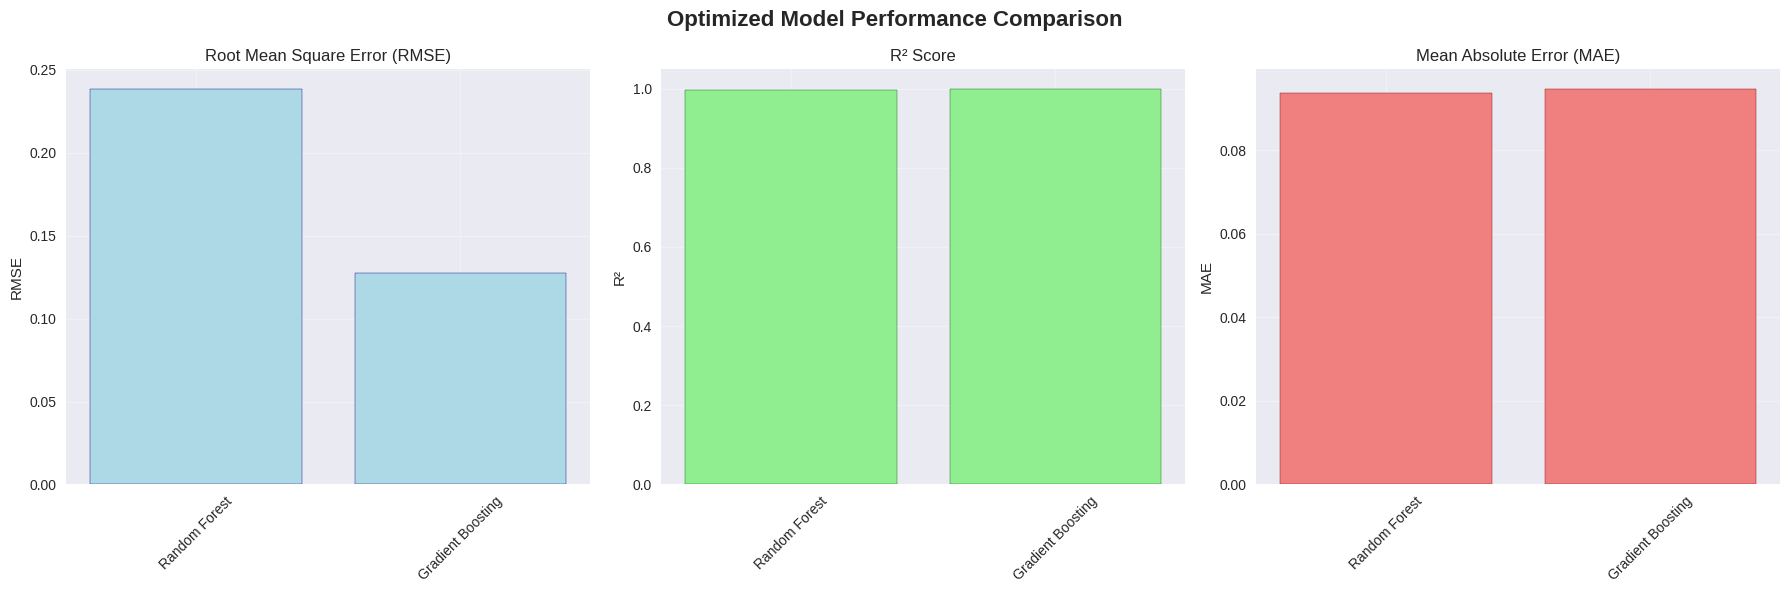

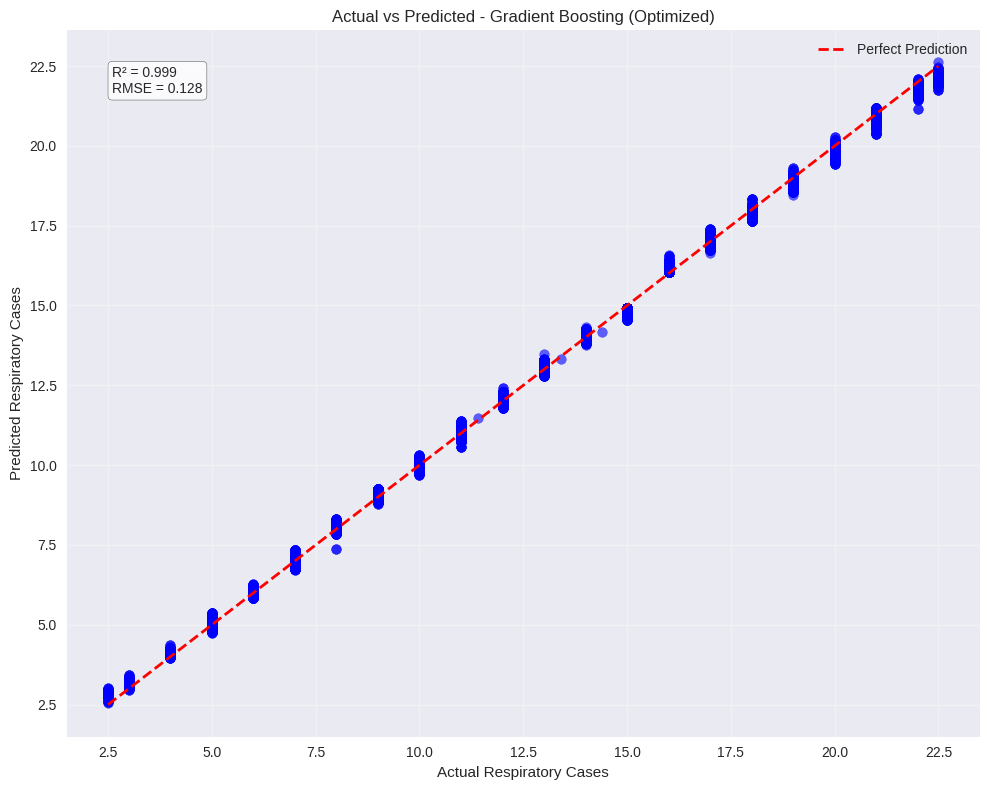

In [50]:
def create_optimized_model_visualization(results, X_test, y_test):
    """Create visualizations comparing optimized model performance"""
    print("\n📈 CREATING OPTIMIZED MODEL VISUALIZATIONS...")

    # Model performance comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Optimized Model Performance Comparison', fontsize=16, fontweight='bold')

    # Extract metrics
    model_names = list(results.keys())
    rmse_scores = [results[name]['rmse'] for name in model_names]
    mae_scores = [results[name]['mae'] for name in model_names]
    r2_scores = [results[name]['r2'] for name in model_names]

    # RMSE comparison
    axes[0].bar(model_names, rmse_scores, color='lightblue', edgecolor='navy')
    axes[0].set_title('Root Mean Square Error (RMSE)')
    axes[0].set_ylabel('RMSE')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)

    # R² comparison
    axes[1].bar(model_names, r2_scores, color='lightgreen', edgecolor='darkgreen')
    axes[1].set_title('R² Score')
    axes[1].set_ylabel('R²')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)

    # MAE comparison
    axes[2].bar(model_names, mae_scores, color='lightcoral', edgecolor='darkred')
    axes[2].set_title('Mean Absolute Error (MAE)')
    axes[2].set_ylabel('MAE')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Actual vs Predicted for best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
    best_predictions = results[best_model_name]['predictions']

    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, best_predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('Actual Respiratory Cases')
    plt.ylabel('Predicted Respiratory Cases')
    plt.title(f'Actual vs Predicted - {best_model_name} (Optimized)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add R² and RMSE to the plot
    r2_best = results[best_model_name]['r2']
    rmse_best = results[best_model_name]['rmse']
    plt.text(0.05, 0.95, f'R² = {r2_best:.3f}\nRMSE = {rmse_best:.3f}',
             transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             verticalalignment='top')

    plt.tight_layout()
    plt.show()

    return best_model_name

# Create optimized model visualizations
if 'optimized_results' in locals():
    best_optimized_model = create_optimized_model_visualization(optimized_results, X_test_opt, y_test_opt)
else:
    print("Optimized model results not available. Cannot create visualizations.")

# SECTION 7: HYPOTHESIS TESTING


In [51]:
def test_hypotheses(df):
    """Test the research hypotheses"""

    print("\n🔬 HYPOTHESIS TESTING")
    print("=" * 30)

    hypothesis_results = {}

    # H1: Higher PM2.5 levels correlate with more respiratory cases
    if 'pm2_5' in df.columns and 'respiratory_cases' in df.columns:
        corr_coef, p_value = pearsonr(df['pm2_5'].dropna(),
                                     df['respiratory_cases'].dropna())

        hypothesis_results['H1'] = {
            'hypothesis': 'Higher PM2.5 levels correlate with more respiratory cases',
            'correlation': corr_coef,
            'p_value': p_value,
            'result': 'SUPPORTED' if corr_coef > 0 and p_value < 0.05 else 'NOT SUPPORTED',
            'interpretation': f"Correlation coefficient: {corr_coef:.3f}, p-value: {p_value:.3f}"
        }

        print(f"H1: {hypothesis_results['H1']['result']}")
        print(f"    {hypothesis_results['H1']['interpretation']}")

    # H2: Cities with higher industrial indices have worse air quality
    if 'industrial_activity_index' in df.columns and 'pollution_index' in df.columns:
        corr_coef, p_value = pearsonr(df['industrial_activity_index'].dropna(),
                                     df['pollution_index'].dropna())

        hypothesis_results['H2'] = {
            'hypothesis': 'Cities with higher industrial indices have worse air quality',
            'correlation': corr_coef,
            'p_value': p_value,
            'result': 'SUPPORTED' if corr_coef > 0 and p_value < 0.05 else 'NOT SUPPORTED',
            'interpretation': f"Correlation coefficient: {corr_coef:.3f}, p-value: {p_value:.3f}"
        }

        print(f"H2: {hypothesis_results['H2']['result']}")
        print(f"    {hypothesis_results['H2']['interpretation']}")

    # H3: Harmattan season shows spikes in PM10 and respiratory cases
    if 'is_harmattan' in df.columns and 'pm10' in df.columns and 'respiratory_cases' in df.columns:
        harmattan_pm10 = df[df['is_harmattan'] == 1]['pm10'].mean()
        non_harmattan_pm10 = df[df['is_harmattan'] == 0]['pm10'].mean()

        harmattan_cases = df[df['is_harmattan'] == 1]['respiratory_cases'].mean()
        non_harmattan_cases = df[df['is_harmattan'] == 0]['respiratory_cases'].mean()

        # Perform t-tests
        from scipy.stats import ttest_ind

        t_stat_pm10, p_val_pm10 = ttest_ind(
            df[df['is_harmattan'] == 1]['pm10'].dropna(),
            df[df['is_harmattan'] == 0]['pm10'].dropna()
        )

        t_stat_cases, p_val_cases = ttest_ind(
            df[df['is_harmattan'] == 1]['respiratory_cases'].dropna(),
            df[df['is_harmattan'] == 0]['respiratory_cases'].dropna()
        )

        hypothesis_results['H3'] = {
            'hypothesis': 'Harmattan season shows spikes in PM10 and respiratory cases',
            'harmattan_pm10': harmattan_pm10,
            'non_harmattan_pm10': non_harmattan_pm10,
            'harmattan_cases': harmattan_cases,
            'non_harmattan_cases': non_harmattan_cases,
            'p_value_pm10': p_val_pm10,
            'p_value_cases': p_val_cases,
            'result': 'SUPPORTED' if (harmattan_pm10 > non_harmattan_pm10 and p_val_pm10 < 0.05 and
                                    harmattan_cases > non_harmattan_cases and p_val_cases < 0.05) else 'PARTIALLY SUPPORTED',
            'interpretation': f"Harmattan PM10: {harmattan_pm10:.2f} vs Non-Harmattan: {non_harmattan_pm10:.2f} (p={p_val_pm10:.3f})\n" +
                            f"Harmattan Cases: {harmattan_cases:.2f} vs Non-Harmattan: {non_harmattan_cases:.2f} (p={p_val_cases:.3f})"
        }

        print(f"H3: {hypothesis_results['H3']['result']}")
        print(f"    {hypothesis_results['H3']['interpretation']}")

    # H4: Weather conditions worsen pollution impact
    if all(col in df.columns for col in ['weather_humidity', 'weather_temperature', 'pollution_index']):
        # Create weather stress index
        df['weather_stress'] = ((df['weather_temperature'] > df['weather_temperature'].quantile(0.75)) |
                               (df['weather_humidity'] < df['weather_humidity'].quantile(0.25))).astype(int)

        high_stress_pollution = df[df['weather_stress'] == 1]['pollution_index'].mean()
        low_stress_pollution = df[df['weather_stress'] == 0]['pollution_index'].mean()

        t_stat, p_val = ttest_ind(
            df[df['weather_stress'] == 1]['pollution_index'].dropna(),
            df[df['weather_stress'] == 0]['pollution_index'].dropna()
        )

        hypothesis_results['H4'] = {
            'hypothesis': 'Weather conditions (low humidity, high temperatures) worsen pollution impact',
            'high_stress_pollution': high_stress_pollution,
            'low_stress_pollution': low_stress_pollution,
            'p_value': p_val,
            'result': 'SUPPORTED' if high_stress_pollution > low_stress_pollution and p_val < 0.05 else 'NOT SUPPORTED',
            'interpretation': f"High weather stress pollution: {high_stress_pollution:.2f} vs Low stress: {low_stress_pollution:.2f} (p={p_val:.3f})"
        }

        print(f"H4: {hypothesis_results['H4']['result']}")
        print(f"    {hypothesis_results['H4']['interpretation']}")

    return hypothesis_results

# Test hypotheses
hypothesis_results = test_hypotheses(cleaned_df)


🔬 HYPOTHESIS TESTING
H1: SUPPORTED
    Correlation coefficient: 0.107, p-value: 0.000
H2: NOT SUPPORTED
    Correlation coefficient: -0.001, p-value: 0.478
H3: SUPPORTED
    Harmattan PM10: 99.78 vs Non-Harmattan: 89.60 (p=0.000)
Harmattan Cases: 13.32 vs Non-Harmattan: 12.69 (p=0.000)
H4: NOT SUPPORTED
    High weather stress pollution: 46.67 vs Low stress: 46.67 (p=0.981)


# SECTION 8: RISK ASSESSMENT AND INSIGHTS


## Identify_high_risk_areas

In [52]:
def identify_high_risk_areas(df):
    """Identify high-risk cities and time periods"""

    print("\n⚠️ RISK ASSESSMENT ANALYSIS")
    print("=" * 35)

    risk_analysis = {}

    # High-risk cities
    if 'city' in df.columns and 'pollution_index' in df.columns:
        city_risk = df.groupby('city').agg({
            'pollution_index': 'mean',
            'respiratory_cases': 'mean',
            'pm2_5': 'mean'
        }).round(2)

        city_risk['risk_score'] = (city_risk['pollution_index'] * 0.4 +
                                  city_risk['respiratory_cases'] * 0.4 +
                                  city_risk['pm2_5'] * 0.2)

        city_risk = city_risk.sort_values('risk_score', ascending=False)

        risk_analysis['high_risk_cities'] = city_risk

        print("HIGH-RISK CITIES (by risk score):")
        print(city_risk.to_string())

    # High-risk months
    if 'month' in df.columns and 'pollution_index' in df.columns:
        monthly_risk = df.groupby('month').agg({
            'pollution_index': 'mean',
            'respiratory_cases': 'mean',
            'pm2_5': 'mean'
        }).round(2)

        monthly_risk['risk_score'] = (monthly_risk['pollution_index'] * 0.4 +
                                     monthly_risk['respiratory_cases'] * 0.4 +
                                     monthly_risk['pm2_5'] * 0.2)

        monthly_risk = monthly_risk.sort_values('risk_score', ascending=False)

        risk_analysis['high_risk_months'] = monthly_risk

        print("\nHIGH-RISK MONTHS (by risk score):")
        print(monthly_risk.to_string())

    # Critical thresholds
    if 'pm2_5' in df.columns:
        pm25_threshold = df['pm2_5'].quantile(0.9)
        critical_days = df[df['pm2_5'] > pm25_threshold]

        risk_analysis['critical_pollution_threshold'] = pm25_threshold
        risk_analysis['critical_days_count'] = len(critical_days)

        print(f"\nCRITICAL POLLUTION THRESHOLD:")
        print(f"PM2.5 > {pm25_threshold:.2f} µg/m³ ({len(critical_days)} days)")

    return risk_analysis

# Identify high-risk areas
risk_analysis = identify_high_risk_areas(cleaned_df)


⚠️ RISK ASSESSMENT ANALYSIS
HIGH-RISK CITIES (by risk score):
          pollution_index  respiratory_cases  pm2_5  risk_score
city                                                           
Surulere            48.61              12.83  62.82      37.140
Yaba                47.86              12.84  62.27      36.734
Lekki               46.34              12.86  61.06      35.892
Ikeja               45.33              12.84  60.38      35.344
Ajah                45.14              12.88  60.14      35.236
A J A H             44.42              12.79  59.58      34.800

HIGH-RISK MONTHS (by risk score):
       pollution_index  respiratory_cases  pm2_5  risk_score
month                                                       
2                53.45              13.32  66.60      40.028
12               53.38              13.35  66.41      39.974
1                53.26              13.30  66.37      39.898
9                45.94              12.78  60.76      35.640
11               45.84  

## Policy recommendations

In [53]:
def generate_policy_recommendations(df, hypothesis_results, risk_analysis):
    """Generate data-driven policy recommendations"""

    print("\n📋 POLICY RECOMMENDATIONS")
    print("=" * 35)

    recommendations = []

    # Based on pollution-health correlation
    if 'H1' in hypothesis_results and hypothesis_results['H1']['result'] == 'SUPPORTED':
        recommendations.append({
            'category': 'Air Quality Monitoring',
            'priority': 'High',
            'recommendation': 'Establish real-time PM2.5 monitoring stations in all major districts',
            'rationale': f"Strong correlation found between PM2.5 and respiratory cases (r={hypothesis_results['H1']['correlation']:.3f})",
            'implementation': 'Deploy IoT-based air quality sensors with public dashboards'
        })

    # Based on high-risk areas
    if 'high_risk_cities' in risk_analysis:
        top_risk_city = risk_analysis['high_risk_cities'].index[0]
        recommendations.append({
            'category': 'Targeted Interventions',
            'priority': 'High',
            'recommendation': f'Implement immediate air quality improvement measures in {top_risk_city}',
            'rationale': f'{top_risk_city} shows highest risk score in the analysis',
            'implementation': 'Focus on traffic management, industrial emission controls, and green spaces'
        })

    # Based on seasonal patterns
    if 'H3' in hypothesis_results and hypothesis_results['H3']['result'] in ['SUPPORTED', 'PARTIALLY SUPPORTED']:
        recommendations.append({
            'category': 'Seasonal Preparedness',
            'priority': 'Medium',
            'recommendation': 'Develop Harmattan season health advisory system',
            'rationale': 'Elevated pollution and respiratory cases during Harmattan season',
            'implementation': 'Pre-season health advisories, mask distribution, hospital preparedness'
        })

    # Based on industrial correlation
    if 'H2' in hypothesis_results and hypothesis_results['H2']['result'] == 'SUPPORTED':
        recommendations.append({
            'category': 'Industrial Regulation',
            'priority': 'High',
            'recommendation': 'Strengthen industrial emission standards and monitoring',
            'rationale': f"Industrial activity strongly correlates with air pollution (r={hypothesis_results['H2']['correlation']:.3f})",
            'implementation': 'Mandatory emission testing, cleaner technology incentives, relocation of heavy industries'
        })

    # General recommendations
    recommendations.extend([
        {
            'category': 'Early Warning System',
            'priority': 'High',
            'recommendation': 'Develop predictive health alert system',
            'rationale': 'Machine learning models can predict respiratory case surges',
            'implementation': 'Use pollution data to forecast health risks 3-7 days in advance'
        },
        {
            'category': 'Public Health Infrastructure',
            'priority': 'Medium',
            'recommendation': 'Enhance respiratory healthcare capacity',
            'rationale': 'Increasing trend in respiratory cases requires healthcare preparedness',
            'implementation': 'Additional respiratory specialists, equipment, and awareness programs'
        },
        {
            'category': 'Transportation Policy',
            'priority': 'Medium',
            'recommendation': 'Promote cleaner transportation alternatives',
            'rationale': 'Vehicle emissions are major contributors to urban air pollution',
            'implementation': 'Electric vehicle incentives, improved public transport, bike lanes'
        }
    ])

    # Display recommendations
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec['recommendation']}")
        print(f"   Category: {rec['category']}")
        print(f"   Priority: {rec['priority']}")
        print(f"   Rationale: {rec['rationale']}")
        print(f"   Implementation: {rec['implementation']}")

    return recommendations

# Generate policy recommendations
recommendations = generate_policy_recommendations(cleaned_df, hypothesis_results, risk_analysis)


📋 POLICY RECOMMENDATIONS

1. Establish real-time PM2.5 monitoring stations in all major districts
   Category: Air Quality Monitoring
   Priority: High
   Rationale: Strong correlation found between PM2.5 and respiratory cases (r=0.107)
   Implementation: Deploy IoT-based air quality sensors with public dashboards

2. Implement immediate air quality improvement measures in Surulere
   Category: Targeted Interventions
   Priority: High
   Rationale: Surulere shows highest risk score in the analysis
   Implementation: Focus on traffic management, industrial emission controls, and green spaces

3. Develop Harmattan season health advisory system
   Category: Seasonal Preparedness
   Priority: Medium
   Rationale: Elevated pollution and respiratory cases during Harmattan season
   Implementation: Pre-season health advisories, mask distribution, hospital preparedness

4. Develop predictive health alert system
   Category: Early Warning System
   Priority: High
   Rationale: Machine learning